In [1]:
maf_file_path = 'data/RESPOND_247_coding_final.maf'
expression_file_path = 'data/Expression_remove_BE.txt'
target_gene='RPL10'

import pandas as pd
import numpy as np
from statistics import mean 
from scipy.stats import ranksums
import matplotlib.pylab as plt
from statsmodels.stats import multitest


In [2]:
def load_maf_data(file_path):
    # Define columns of interest
    columns = ["Hugo_Symbol", "Tumor_Sample_Barcode"]
    df = pd.read_csv(file_path, sep='\t', comment="#", usecols=columns)
    df.rename(columns={'Hugo_Symbol': 'gene', 'Tumor_Sample_Barcode': 'sample'}, inplace=True)
    df['mutation'] = 1
    return df
    
maf_df = load_maf_data(maf_file_path)



In [3]:
def log2(value):
    return np.log2(value + 1)

def load_txt_file_into_dataframe(file_path):
    # Read the .txt file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t')  # Adjust the separator if needed

    # take log2 of expression data to scale expression data
    df = df.map(log2)

    return df


# Call the load_txt_file_into_dataframe function
expression_df = load_txt_file_into_dataframe(expression_file_path)

In [4]:
def reformat_expression_data(df):
    # Combine column names and index names into rows for every element
    melted_df = pd.melt(df.reset_index(), id_vars=['index'], var_name='column', col_level=0)

    # Rename columns
    melted_df.rename(columns={'index': 'gene', 'column': 'sample', 'value': 'gene_expression'}, inplace=True)

    return melted_df


expression_df_melted = reformat_expression_data(expression_df)

In [74]:
expression_df_melted[expression_df_melted['gene'] == target_gene]

,gene,sample,gene_expression
14658,RPL10,RESPOND_10100218,7.599913
34659,RPL10,RESPOND_10100291,7.169925
54660,RPL10,RESPOND_10100412,7.219169
74661,RPL10,RESPOND_10100478,7.787903
94662,RPL10,RESPOND_10100596,7.800900
...,...,...,...
3194817,RPL10,RESPOND_80100556,8.794416
3214818,RPL10,RESPOND_80100590,7.787903
3234819,RPL10,RESPOND_81100031,7.266787
3254820,RPL10,RESPOND_40100842,7.651052


In [5]:
# note individuals with muttated data mmay be missing in the expression data and vice versa. 
# every sample should have at least one mutation 

In [6]:
def preprocess_and_combine_mutation_expression(maf_df, expression_df):
    ''' filter the expression data to those that have whole genome sequencing 
     i.e. appear in the mutation data frame (maf)
     join mutation and expression data
     '''
    
    exon_seq_samples = maf_df['sample'].unique()
    filtered_expression_df = expression_df[expression_df['sample'].isin(exon_seq_samples)]
    
    all_rows = expression_df.shape[0]
    filt_rows = filtered_expression_df.shape[0]
    
    percentage_filtered = (all_rows - filt_rows) / all_rows
    
    print('fraction of rows filtered is', percentage_filtered)

    express_mut_genes_df = pd.merge(maf_df, filtered_expression_df, on=['gene', 'sample'], how='right')

    express_mut_genes_df['mutation'].fillna(0, inplace=True)

    return express_mut_genes_df


mutation_expression_df_melted =  preprocess_and_combine_mutation_expression(maf_df, expression_df_melted)
    

fraction of rows filtered is 0.2865853658536585


In [7]:
def calculate_log_fold(list_mutated, list_non_mutated, smoothing_factor=1e-8): 
    mean_mutated = mean(list_mutated)  + smoothing_factor
    mean_non_mutated = mean(list_non_mutated) + smoothing_factor

    # if np.isclose(mean_non_mutated, 0):
    #     print(f'the denominator is zero in log2 with a value of {mean_non_mutated}')
    #     return np.nan
        
    return np.log2(mean_mutated/mean_non_mutated)

In [8]:
def calculate_z_score(list_mutated, list_non_mutated):
    mean_mutated = mean(list_mutated) 
    mean_non_mutated = mean(list_non_mutated) 
    all_expression_values = list_non_mutated + list_mutated
    z_score = (mean_mutated - mean_non_mutated) / np.std(all_expression_values)
    return z_score


In [9]:
def calculate_pvalue_and_effect_size_wilcox_ranksum(list_mutated, list_non_mutated):
     test = ranksums(list_mutated, list_non_mutated)
     u_statistic = test.statistic 
     effect_size = u_statistic / (len(list_mutated) * len(list_non_mutated))
     pvalue=test.pvalue
     return pvalue, effect_size

In [10]:
def calculate_adjusted_pvalue(pvalues, method='fdr_bh'):
    _, corrected_pvalues, _, _ = multitest.multipletests(pvalues, method=method)
    return corrected_pvalues


In [11]:
import os
def generate_stats_per_gene(express_mut_genes_df, target_gene, output_folder=target_gene):
    """
    Given expression and mutation data calculates LogFC, pvalue, mean of expression per gene 
    for a given target_gene 
    
    """
    gene_df = express_mut_genes_df[express_mut_genes_df['gene']==target_gene]

    mutated_samples = gene_df[gene_df['mutation'] == 1]['sample']
    non_mutated_samples = gene_df[gene_df['mutation'] == 0]['sample']
    
    mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(mutated_samples)]
    
    non_mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(non_mutated_samples)]

    # gather data of mutated and non-mutated genes into lists
    mutated_individuals_data = mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_mutated'})
    non_mutated_individuals_data = non_mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_non_mutated'})

    # combine mutated and unmutated data into one df
    combined_data= pd.merge(mutated_individuals_data, non_mutated_individuals_data, on='gene', how='inner')

    # calculate fold change and p-value and z-score
    combined_data['logFC']= combined_data.apply(
        lambda x: calculate_log_fold(x.gene_expression_mutated, x.gene_expression_non_mutated), axis=1)
    # Assuming combined_data is a DataFrame
    combined_data[['pvalue', 'effect_size']] = combined_data.apply(
    lambda x: pd.Series(calculate_pvalue_and_effect_size_wilcox_ranksum(x.gene_expression_mutated, x.gene_expression_non_mutated)),
    axis=1
    )
    combined_data['expression_mutated_mean'] = combined_data['gene_expression_mutated'].apply(mean)
    combined_data['expression_nonmutated_mean'] = combined_data['gene_expression_non_mutated'].apply(mean)


    # calculate adjusted p-value
    combined_data['adjusted_pvalue'] = calculate_adjusted_pvalue(combined_data['pvalue'].values)

    # Output data to csv 
    combined_data.drop(columns=['gene_expression_mutated', 'gene_expression_non_mutated'], inplace=True)
    
    os.makedirs(output_folder, exist_ok=True)
    output_filename = f'{output_folder}/{mutated_samples.count()}_{non_mutated_samples.count()}_logfc_pvalue.csv'
    
    print(f"outputting data to {output_filename}")
    combined_data.to_csv(output_filename, index=False)

    return combined_data, mutated_samples, output_filename


In [12]:
volcano_plot_df, individuals_mutated_target_gene, volcano_input_filename = generate_stats_per_gene(
    mutation_expression_df_melted, 
    target_gene)

outputting data to RPL10/5_112_logfc_pvalue.csv


In [13]:
volcano_plot_df

,gene,logFC,pvalue,effect_size,expression_mutated_mean,expression_nonmutated_mean,adjusted_pvalue
0,A1BG,-0.357606,0.526496,-0.001131,1.796602,2.301983,0.996941
1,A1CF,0.419188,0.589864,0.000963,0.770841,0.576470,0.996941
2,A2M,-0.058985,0.496169,-0.001215,7.180720,7.480391,0.996941
3,A2ML1,0.544969,0.140050,0.002635,1.805403,1.237434,0.996941
4,A3GALT2,0.183454,0.761733,0.000541,0.331263,0.291708,0.996941
...,...,...,...,...,...,...,...
19996,ZXDC,0.025356,0.898133,0.000229,5.923805,5.820600,0.996941
19997,ZYG11A,0.647638,0.035533,0.003754,1.981378,1.264763,0.996941
19998,ZYG11B,0.145653,0.188882,0.002346,3.902844,3.528054,0.996941
19999,ZYX,-0.133048,0.097413,-0.002960,7.000198,7.676475,0.996941


## generate heatmap of top 100 differentially expressed genes

In [14]:
def generate_expression_heatmap(expression_df, volcano_plot_df, n=100, exclude_value=10):
    # Get the indices of the top n rows based on absolute values of 'logFC'
    # get the genes most differentially expressed (high log FC values)
    # if we exclude -exclude_value, exclude_value values
    # top_n_indices = volcano_plot_df[
    #     (volcano_plot_df['logFC'].abs() != exclude_value)
    # ]['logFC'].abs().nlargest(n).index
    
    # top_n_rows = volcano_plot_df.loc[top_n_indices].set_index('gene')

    top_n_indices = volcano_plot_df['pvalue'].nsmallest(n).index
    
    top_n_rows = volcano_plot_df.loc[top_n_indices].set_index('gene')

    # go back to the expression df and make a heatmap of the top n genes
    expression_df_heatmap = expression_df.loc[top_n_rows.index]
    
    return expression_df_heatmap

heatmap_data = generate_expression_heatmap(expression_df, volcano_plot_df)


In [111]:
heatmap_data.head(3)

,RESPOND_10100218,RESPOND_10100291,RESPOND_10100412,RESPOND_10100478,RESPOND_10100596,RESPOND_10100615,RESPOND_10100801,RESPOND_10100884,RESPOND_10100899,RESPOND_10100952,...,RESPOND_80100242,RESPOND_80100313,RESPOND_80100345,RESPOND_80100411,RESPOND_80100526,RESPOND_80100556,RESPOND_80100590,RESPOND_81100031,RESPOND_40100842,RESPOND_80100259
gene,,,,,,,,,,,,,,,,,,,,,
OR11H2,0.000000,0.159320,0.000000,0.000000,0.060449,0.000000,0.156284,0.037355,0.022295,0.191575,...,0.000000,0.000000,0.000000,0.077743,0.000000,1.584963,0.050964,0.000000,0.049748,0.207237
LRATD2,6.629357,7.651052,6.375039,6.727920,6.820179,5.459432,5.857981,6.442943,6.857981,7.531381,...,5.357552,6.906891,6.523562,6.832890,6.087463,6.930737,6.108524,5.247928,6.321928,5.781360
EDAR,0.025615,1.000000,0.361635,0.015621,0.496133,0.361887,0.217261,0.909977,1.000000,1.584963,...,0.089606,0.315465,1.000000,0.035414,0.522009,0.677811,0.277052,0.230134,0.647555,1.000000


In [18]:
# can check mutation status of genes by checking individuals_mutated_target_gene

In [15]:
import pandas as pd

def get_mutated_status(expression_df_heatmap, individuals_mutated_target_gene, output_folder=target_gene):
    individuals_mutated_target_gene = list(individuals_mutated_target_gene)
    
    mutated_status = [1 if item in individuals_mutated_target_gene else 0 for item in expression_df_heatmap.columns]

    sample_categories_df = pd.DataFrame({
        'Sample': expression_df_heatmap.columns,
        'Mutation Status': mutated_status
    })

    output_filename = f'{output_folder}/sample_mutation_status.csv'
    print(output_filename)
    sample_categories_df.to_csv(output_filename,  index=False)
    return sample_categories_df

mutated_status_df = get_mutated_status(heatmap_data, individuals_mutated_target_gene)


RPL10/sample_mutation_status.csv


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage

def hierarchical_clustering(expression_df_heatmap, row_threshold=7, col_threshold=7, output_folder=target_gene):
    # Cluster the rows and columns using hierarchical clustering
    row_linkage = linkage(expression_df_heatmap, method='ward')
    col_linkage = linkage(expression_df_heatmap.T, method='ward')

    # Assign cluster labels using cluster
    row_clusters = fcluster(row_linkage, t=row_threshold, criterion='maxclust')
    col_clusters = fcluster(col_linkage, t=col_threshold, criterion='maxclust')

    # Create dictionaries to store cluster information
    row_cluster_info = {f"Cluster {cluster}": expression_df_heatmap.index[row_clusters == cluster] for cluster in np.unique(row_clusters)}
    col_cluster_info = {f"Cluster {cluster}": expression_df_heatmap.columns[col_clusters == cluster] for cluster in np.unique(col_clusters)}

    row_cluster_file = os.path.join(output_folder, 'row_clusters.txt')
    with open(row_cluster_file, 'w') as file:
        for cluster, items in row_cluster_info.items():
            file.write(f"{cluster}:\n")
            file.write(f"{', '.join(items)}\n\n")

    # Save column cluster information to a text file
    col_cluster_file = os.path.join(output_folder, 'col_clusters.txt')
    with open(col_cluster_file, 'w') as file:
        for cluster, items in col_cluster_info.items():
            file.write(f"{cluster}:\n")
            file.write(f"{', '.join(items)}\n\n")
    
    return row_linkage, col_linkage, row_cluster_info, col_cluster_info


row_linkage, col_linkage, row_clusters, col_clusters = hierarchical_clustering(heatmap_data)


In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_clustered_heatmap_and_save(expression_df_heatmap, 
                                      row_linkage, 
                                      col_linkage, 
                                      sample_mutation_df, 
                                      output_folder=target_gene):
    # Group labels and colors for color bar
    type_map = {1: 'red', 0: 'yellow'}

    # Create a clustered heatmap
    clustered_df = sns.clustermap(
        expression_df_heatmap,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        cmap='viridis',
        annot=True,
        fmt=".1f",
        linewidths=.5,
        col_colors=sample_mutation_df.set_index('Sample')['Mutation Status'].map(type_map),
        standard_scale=0  # standardize by the rows
    )
    output_filename = f'{output_folder}/heatmap.png'
    
    # Save the plot to a file
    clustered_df.savefig(output_filename)

    # Close the plot to prevent displaying it in the notebook (optional)
    plt.close()

    return clustered_df

clustered_heatmap = create_clustered_heatmap_and_save(heatmap_data, 
                                                      row_linkage, 
                                                      col_linkage,
                                                      mutated_status_df)


In [131]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

## add more args to the function 

def plot_and_save_dendrograms(row_linkage, col_linkage, expression_df_heatmap, output_folder=target_gene):
    # Plot the row dendrogram
    plt.figure(figsize=(12, 10))
    # play around with fig sizes 
    gene_plot = dendrogram(row_linkage, 
                           labels=expression_df_heatmap.index, 
                           truncate_mode='lastp', 
                           p=int(0.75 * len(row_linkage)), show_leaf_counts=True)
    plt.title('Row Dendrogram')
    
    # Save the row dendrogram plot to a file
    row_dendrogram_filename = f'{output_folder}/row_dendrogram.png'
    plt.savefig(row_dendrogram_filename)
    plt.close()

    # Plot the column dendrogram
    # play around with fig sizes 
    plt.figure(figsize=(12, 10))
    sample_plot = dendrogram(col_linkage, labels=expression_df_heatmap.columns, orientation='top', 
                             truncate_mode='lastp', p=int(0.75 * len(row_linkage)), show_leaf_counts=True)
    plt.title('Column Dendrogram')
    
    # Save the column dendrogram plot to a file
    col_dendrogram_filename = f'{output_folder}/col_dendrogram.png'
    plt.savefig(col_dendrogram_filename)
    plt.close()

    return gene_plot, sample_plot

row_dendrogram, col_dendrogram = plot_and_save_dendrograms(row_linkage, 
                                                           col_linkage, 
                                                           heatmap_data)


In [129]:
def histogram_of_column_and_save(df, column, output_folder=target_gene):
    # Plot the distribution of p-values
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel('P-values')
    plt.ylabel('Frequency')

    output_filename = f'{output_folder}/histogram_{column}.png'
    # Save the histogram plot to a file
    plt.savefig(output_filename)
    plt.close()

histogram_of_column_and_save(volcano_plot_df, 'pvalue')


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def volcano_plot(input_file_path, yaxis, 
                 xaxis, 
                 significance_threshold=0.05, 
                 logfold_positive_threshold=2, 
                 logfold_negative_threshold=-2,
                 output_folder=target_gene):
    df = pd.read_csv(input_file_path)

    # Apply -log10 transformation to the p-value
    df['-log10_pvalue'] = -np.log10(df[yaxis])

    # Highlight significant points with large log-fold changes
    significant_genes_positive = df[(df[yaxis] < significance_threshold) & (df['logFC'] > logfold_positive_threshold)]
    significant_genes_negative = df[(df[yaxis] < significance_threshold) & (df['logFC'] < logfold_negative_threshold)]

    # Clip outliers in 'logFC' column for the plot
    df['logFC'] = df['logFC'].clip(lower=-10, upper=10)

    plt.scatter(x=df[xaxis], y=df['-log10_pvalue'], s=1, label='All Genes', alpha=0.5)
    plt.scatter(x=significant_genes_positive[xaxis], y=significant_genes_positive['-log10_pvalue'], s=10, c='red', marker='^', label='Significant Genes (Positive LogFC)')
    plt.scatter(x=significant_genes_negative[xaxis], y=significant_genes_negative['-log10_pvalue'], s=10, c='blue', marker='v', label='Significant Genes (Negative LogFC)')

    plt.xlabel(xaxis)
    plt.ylabel(f'-log10({yaxis})')
    plt.title('Volcano Plot')
    plt.axhline(-np.log10(significance_threshold), color='gray', linestyle='--', label=f'Significance Threshold ({significance_threshold})')
    plt.axvline(logfold_positive_threshold, color='gray', linestyle='--', label=f'Positive Log-Fold Change Threshold ({logfold_positive_threshold})')
    plt.axvline(logfold_negative_threshold, color='gray', linestyle='--', label=f'Negative Log-Fold Change Threshold ({logfold_negative_threshold})')
    
     # Create a separate legend outside the plot
    fig = plt.gcf()
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    output_filename = f'{output_folder}/volcano_plot.png'
    plt.savefig(output_filename, bbox_inches='tight')
    plt.close()
    significant_genes_positive.to_csv(f'{output_folder}/signif_genes_positive.csv')
    significant_genes_negative.to_csv(f'{output_folder}/signif_genes_negative.csv')

    return significant_genes_positive, significant_genes_negative

significant_genes_positive, significant_genes_negative  = volcano_plot(volcano_input_filename, 'pvalue', 'logFC')


In [50]:
significant_genes_positive

,gene,logFC,pvalue,effect_size,expression_mutated_mean,expression_nonmutated_mean,adjusted_pvalue,-log10_pvalue
2442,CCN6,2.664763,0.012666,0.004452,0.849538,0.133970,0.996941,1.897366
4050,DDX4,2.367873,0.021202,0.004115,0.272597,0.052811,0.996941,1.673623
5259,FAM216B,2.377461,0.033239,0.003802,0.776424,0.149421,0.996941,1.478349
6008,GCM1,2.935524,0.002775,0.005342,0.366724,0.047936,0.996941,2.556756
6567,GSTA2,2.276298,0.032141,0.003826,0.851046,0.175679,0.996941,1.492946
6758,HAO2,2.208746,0.003684,0.005186,0.895719,0.193764,0.996941,2.433705
10942,NXF3,2.044780,0.030036,0.003874,1.063536,0.257758,0.996941,1.522351
11096,OR11H2,2.783007,0.001191,0.005787,0.548934,0.079754,0.996941,2.923953
13949,RN7SL185P,3.437866,0.041866,0.003634,0.110801,0.010225,0.996941,1.378140
14090,RN7SL469P,3.313206,0.043241,0.003610,0.126650,0.012742,0.996941,1.364105


In [46]:
## 1. make box plots of expression comparing mutating idividuals to non-mutated expression levels 
### 2. map signif genes positives to clusters of genes from hierarchial clustering. for each cluster count number of genes in it. 


In [93]:
cand_gene = 'CCN6'
expression_cand_gene = expression_df.loc[cand_gene]


In [94]:
expression_cand_gene = expression_cand_gene.to_frame()

# Specify both column names
expression_cand_gene.columns = ['Expression']

In [99]:
mutated_status_df  = mutated_status_df.set_index('Sample')

In [97]:
merged_df = pd.concat([mutated_status_df, expression_cand_gene], axis=1)

In [104]:
merged_df[merged_df['Mutation Status'] == 1]

,Mutation Status,Expression
RESPOND_10100952,1,0.655483
RESPOND_20101014,1,0.592206
RESPOND_20101598,1,2.000000
RESPOND_70100286,1,0.000000
RESPOND_70100563,1,1.000000


/Users/meltemtutar/miniconda3/envs/huang_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/meltemtutar/miniconda3/envs/huang_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/meltemtutar/miniconda3/envs/huang_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


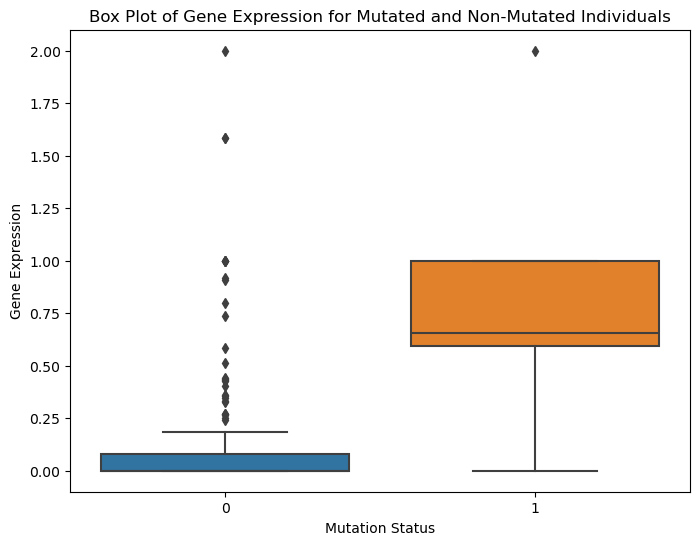

In [102]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Mutation Status', y='Expression', data=merged_df)
plt.xlabel('Mutation Status')
plt.ylabel('Gene Expression')
plt.title('Box Plot of Gene Expression for Mutated and Non-Mutated Individuals')
plt.show()

In [ ]:
# why is there only one dot? on the mutated status part
# not sure how to read box plots 